## Imports

In [1]:
import json

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

#### Styles

In [2]:
plt.style.use("ggplot")

## Data loading

In [3]:
def create_df(path: str):
    with open(path) as f:
        data = json.load(f)

    d = {"match_id": [], "tier": [], "team": [], "participant_puuid": [], "previous_matches": []}
    for match_infos in data:
        for team_100_infos in match_infos["team_100"]:
            d["match_id"].append(match_infos["match_id"])
            d["tier"].append(match_infos["tier"])
            d["team"].append("team_100")
            d["participant_puuid"].append(team_100_infos["participant_puuid"])
            d["previous_matches"].append(team_100_infos["previous_matches"])

        for team_200_infos in match_infos["team_200"]:
            d["match_id"].append(match_infos["match_id"])
            d["tier"].append(match_infos["tier"])
            d["team"].append("team_200")
            d["participant_puuid"].append(team_200_infos["participant_puuid"])
            d["previous_matches"].append(team_200_infos["previous_matches"])
    
    return pd.DataFrame(d)

In [32]:
df1 = create_df("data/data_CHALLENGER_194_1676362154.json")
df2 = create_df("data/data_CHALLENGER_120_1677556324.json")
df3 = create_df("data/data_GRANDMASTER_255_1676435692.json")
df4 = create_df("data/data_GRANDMASTER_137_1677595544.json")
df5 = create_df("data/data_MASTER_270_1676513097.json")
df6 = create_df("data/data_MASTER_146_1677635130.json")
df7 = create_df("data/data_DIAMOND_444_1676712036.json")
df8 = create_df("data/data_DIAMOND_493_1677513543.json")
df9 = create_df("data/data_PLATINUM_493_1676859938.json")
df10 = create_df("data/data_PLATINUM_300_1677872200.json")
df11 = create_df("data/data_GOLD_497_1677002242.json")
df12 = create_df("data/data_GOLD_300_1677945536.json")
df13 = create_df("data/data_SILVER_499_1677125835.json")
df14 = create_df("data/data_SILVER_300_1678028356.json")
df15 = create_df("data/data_BRONZE_495_1677247223.json")
df16 = create_df("data/data_BRONZE_299_1678101303.json")
df17 = create_df("data/data_IRON_496_1677389699.json")
df18 = create_df("data/data_IRON_298_1678193119.json")

In [33]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18])

In [34]:
duplicated = df.loc[:, ["match_id", "participant_puuid"]].duplicated(keep="first")
df_no_duplicates = df.loc[~duplicated, :].copy()

In [35]:
df_no_duplicates["tier"] = df_no_duplicates.tier.apply(lambda x: "MASTER+" if x in ["CHALLENGER", "GRANDMASTER", "MASTER"] else x)

In [36]:
number_matches = len(df_no_duplicates.match_id.unique())
print(f"Unique matches : {number_matches}")
print(f"Unique Teams : {number_matches*2}")

Unique matches : 5999
Unique Teams : 11998


In [40]:
# Distribution of matches by tier
df_no_duplicates.loc[:, ["tier", "match_id"]].value_counts().groupby("tier").count()

tier
BRONZE       794
DIAMOND      935
GOLD         796
IRON         793
MASTER+     1091
PLATINUM     791
SILVER       799
dtype: int64

## Statistics

In [41]:
def create_df_with_statitic(df, apply_func):
    df = df.copy()
    df["stat_value"] = df.previous_matches.apply(apply_func)
    
    match_not_to_be_count = df.loc[df.stat_value.isna(), "match_id"].unique()
    new_df = df.loc[~df.match_id.isin(match_not_to_be_count), :]
    df_stat = new_df.loc[:, ["match_id", "team", "stat_value", "tier"]].groupby(["match_id", "team", "tier"], as_index=False).mean()
    
    return df_stat

In [42]:
def create_plot(df, title, xlabel, categories = False):
    
    if categories is False:
        fig, ax = plt.subplots(figsize=(20,10))

        sns.kdeplot(data=df, x="stat_value", ax=ax, fill=True, cut=0, label="All tiers")
    
    else:
        categories = df.tier.unique()
        
        fig, ax = plt.subplots(figsize=(20,10))
        
        for categorie in categories:
            sns.kdeplot(data=df.loc[df.tier == categorie, :], x="stat_value", ax=ax, cut=0, label=f"{categorie} tier")
            
        
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Density")
    
    plt.tight_layout()
    plt.show()
    

In [43]:
def print_stats(df, categories = False):
    if categories == False:
        print("GLOBAL INFORMATION ON STAT")
        print(f"Average : {df.stat_value.mean():.3}")
        print(f"Median : {df.stat_value.median():.3}")
        print(f"Max. : {df.stat_value.max():.3}")
        print(f"Min. : {df.stat_value.min():.3}")
        print(f"Variance : {df.stat_value.var():.3}")
    
    else:
        categories = df.tier.unique()
        for categorie in categories:
            print(f"INFORMATION ABOUT THE STAT OF THE TIER : '{categorie}'")
            print(f"Average : {df.loc[df.tier == categorie, :].stat_value.mean():.3}")
            print(f"Median : {df.loc[df.tier == categorie, :].stat_value.median():.3}")
            print(f"Max. : {df.loc[df.tier == categorie, :].stat_value.max():.3}")
            print(f"Min. : {df.loc[df.tier == categorie, :].stat_value.min():.3}")
            print(f"Variance : {df.loc[df.tier == categorie, :].stat_value.var():.3}")
            print("---------------")

### 1. The number of defeats in a row

On regarde le nombre de défaites d'affilées des joueurs d'une équipe et on fait la moyenne.

Exemple:
 - Joueur 1: 3 défaites d'affilées
 - Joueur 2: 1 défaites d'affilée
 - Joueur 3: 0 défaites d'affilée
 - Joueur 4: 0 défaites d'affilée
 - Joueur 5: 2 défaites d'affilées
 
  Valeur de la stat : 1.2

In [44]:
def apply_number_of_defeats_in_a_row(x):
    count = 0
    for d in x:
        if d["result"] == "victory":
            return count
        count += 1

In [45]:
df_number_of_defeats_in_a_row = create_df_with_statitic(df_no_duplicates, apply_number_of_defeats_in_a_row)

In [46]:
print(f"Number of teams : {df_number_of_defeats_in_a_row.shape[0]}")

Number of teams : 9970


In [47]:
# Distribution of teams by tier
df_number_of_defeats_in_a_row.tier.value_counts()

MASTER+     2112
DIAMOND     1554
PLATINUM    1282
GOLD        1280
SILVER      1262
BRONZE      1244
IRON        1236
Name: tier, dtype: int64

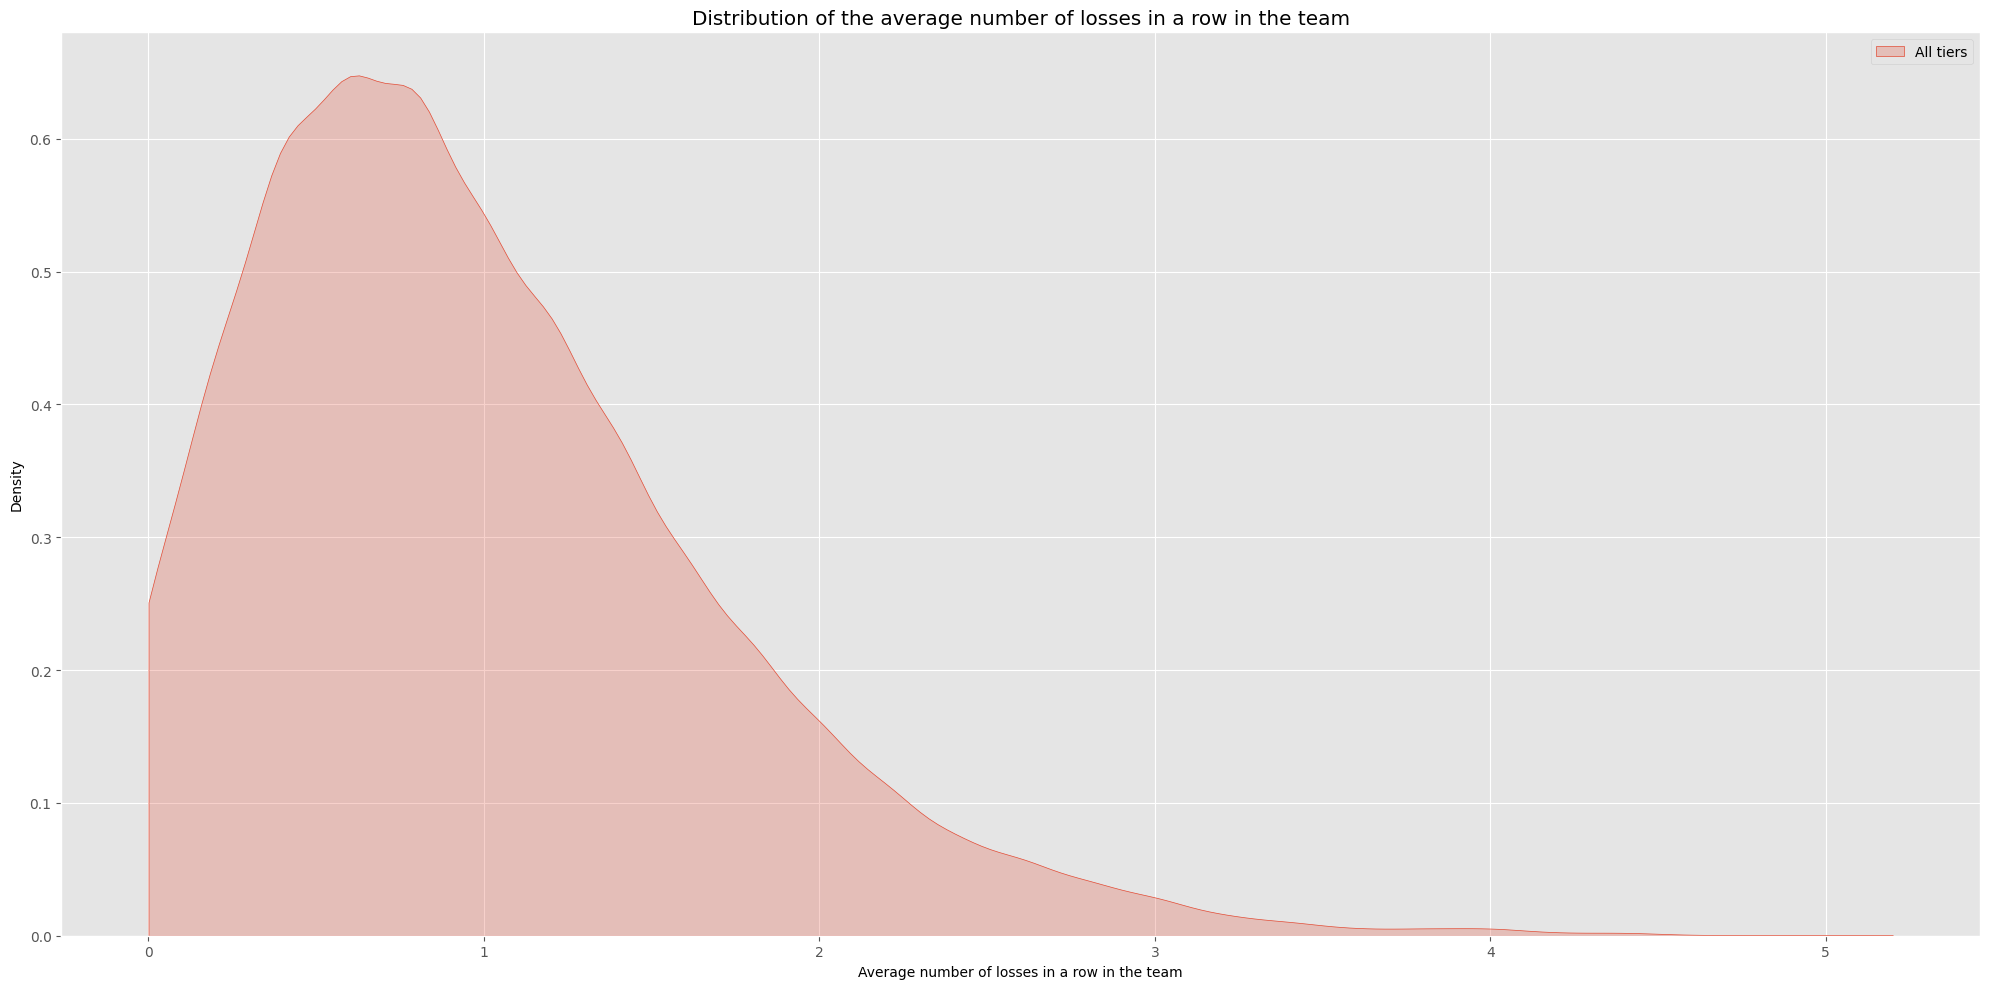

GLOBAL INFORMATION ON STAT
Average : 0.994
Median : 0.8
Max. : 5.2
Min. : 0.0
Variance : 0.483


In [48]:
create_plot(df=df_number_of_defeats_in_a_row,
            title="Distribution of the average number of losses in a row in the team",
            xlabel="Average number of losses in a row in the team")

print_stats(df=df_number_of_defeats_in_a_row)

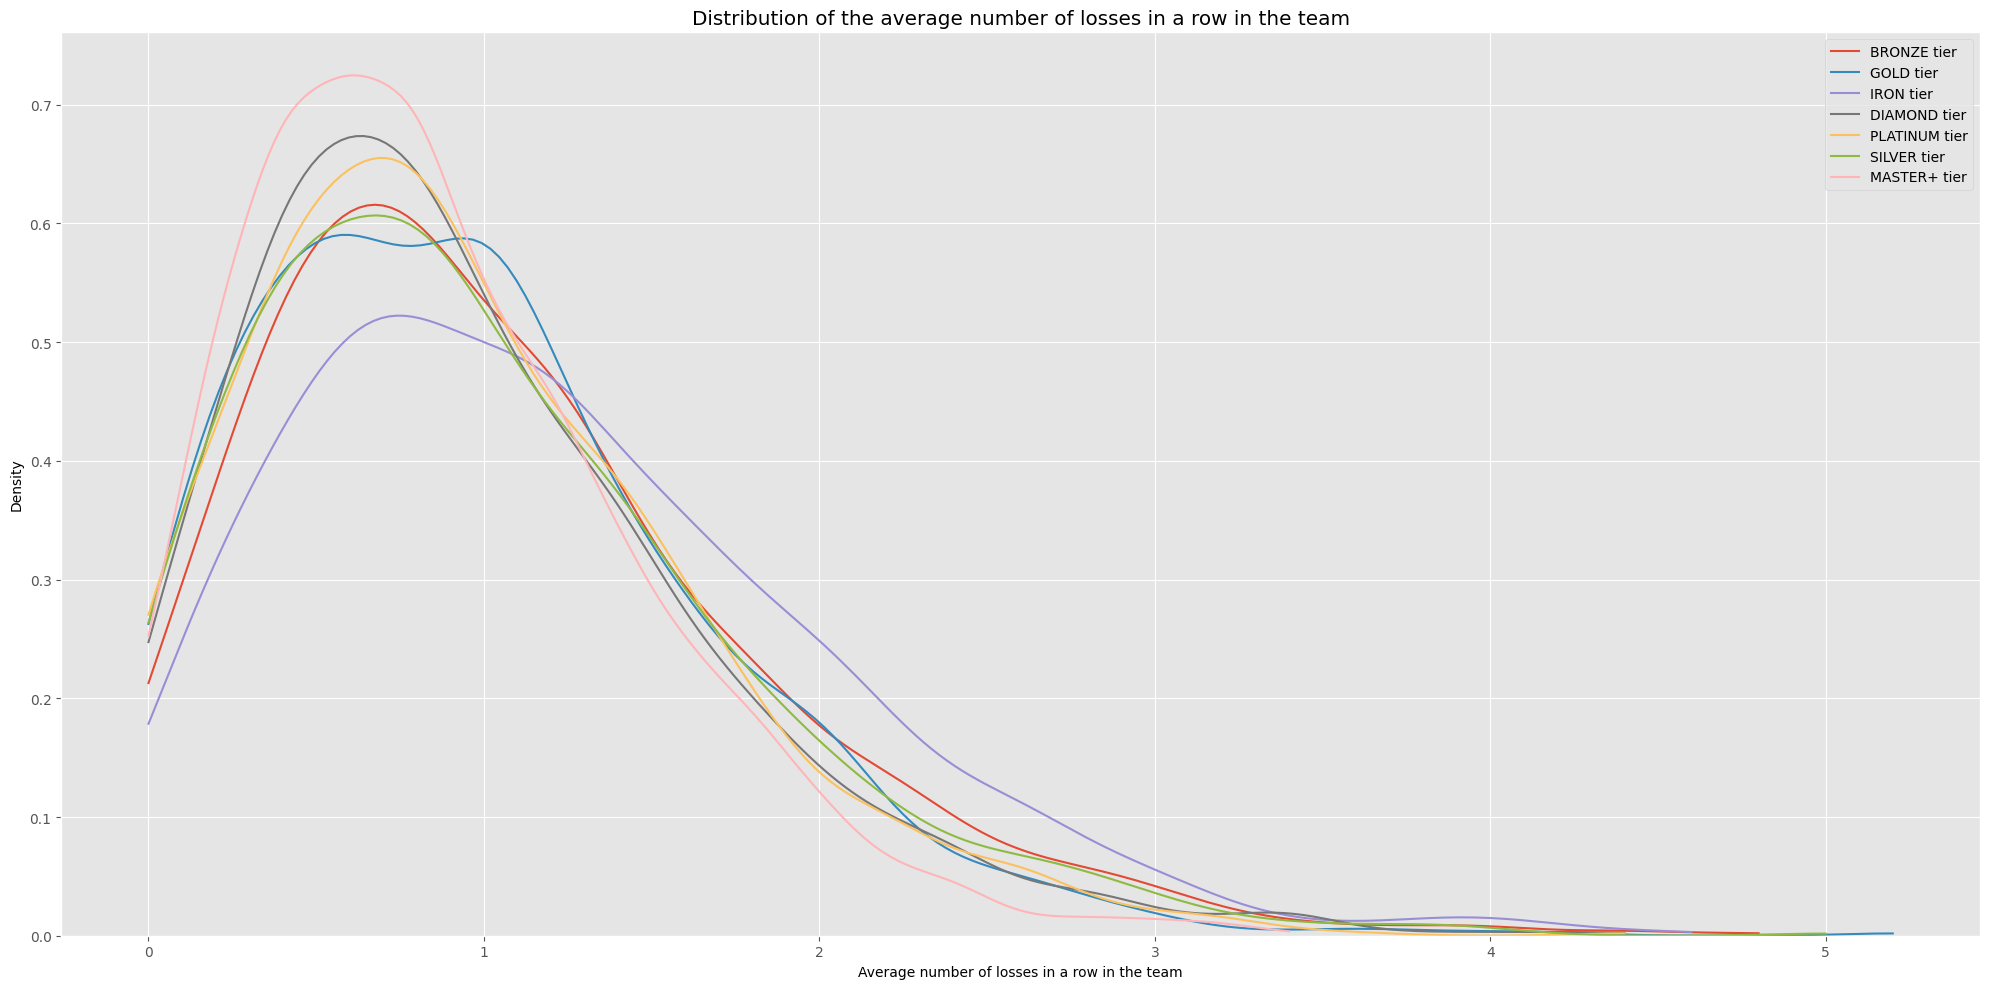

INFORMATION ABOUT THE STAT OF THE TIER : 'BRONZE'
Average : 1.06
Median : 1.0
Max. : 4.8
Min. : 0.0
Variance : 0.551
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'GOLD'
Average : 0.978
Median : 1.0
Max. : 5.2
Min. : 0.0
Variance : 0.457
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'IRON'
Average : 1.21
Median : 1.0
Max. : 4.6
Min. : 0.0
Variance : 0.63
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'DIAMOND'
Average : 0.964
Median : 0.8
Max. : 4.4
Min. : 0.0
Variance : 0.469
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'PLATINUM'
Average : 0.956
Median : 0.8
Max. : 4.4
Min. : 0.0
Variance : 0.436
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'SILVER'
Average : 1.01
Median : 0.8
Max. : 5.0
Min. : 0.0
Variance : 0.529
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'MASTER+'
Average : 0.873
Median : 0.8
Max. : 3.4
Min. : 0.0
Variance : 0.342
---------------


In [49]:
create_plot(df=df_number_of_defeats_in_a_row,
            title="Distribution of the average number of losses in a row in the team",
            xlabel="Average number of losses in a row in the team",
            categories=True)

print_stats(df=df_number_of_defeats_in_a_row, categories=True)

### 2. The sum of losses in the last 10 games

On regarde le nombre de défaites les 10 dernières parties des joueurs d'une équipe et on fait la moyenne.

Exemple:
 - Joueur 1: 3 défaites parmi les 10 dernières parties
 - Joueur 2: 6 défaites parmi les 10 dernières parties
 - Joueur 3: 2 défaites parmi les 10 dernières parties
 - Joueur 4: 8 défaites parmi les 10 dernières parties
 - Joueur 5: 5 défaites parmi les 10 dernières parties
 
  Valeur de la stat : 4.8

In [50]:
def apply_sum_of_losses_in_the_last_10_games(x):
    if len(x) < 10:
        return np.nan
    
    count = 0
    for d in x[0:10]:
        if d["result"] == "defeat":
            count += 1
    
    return count

In [51]:
df_sum_of_losses_in_the_last_10_games = create_df_with_statitic(df_no_duplicates, apply_sum_of_losses_in_the_last_10_games)

In [52]:
print(f"Number of teams : {df_sum_of_losses_in_the_last_10_games.shape[0]}")

Number of teams : 9188


In [53]:
# Distribution of teams by tier
df_sum_of_losses_in_the_last_10_games.tier.value_counts()

MASTER+     2100
DIAMOND     1496
PLATINUM    1204
IRON        1154
GOLD        1088
BRONZE      1086
SILVER      1060
Name: tier, dtype: int64

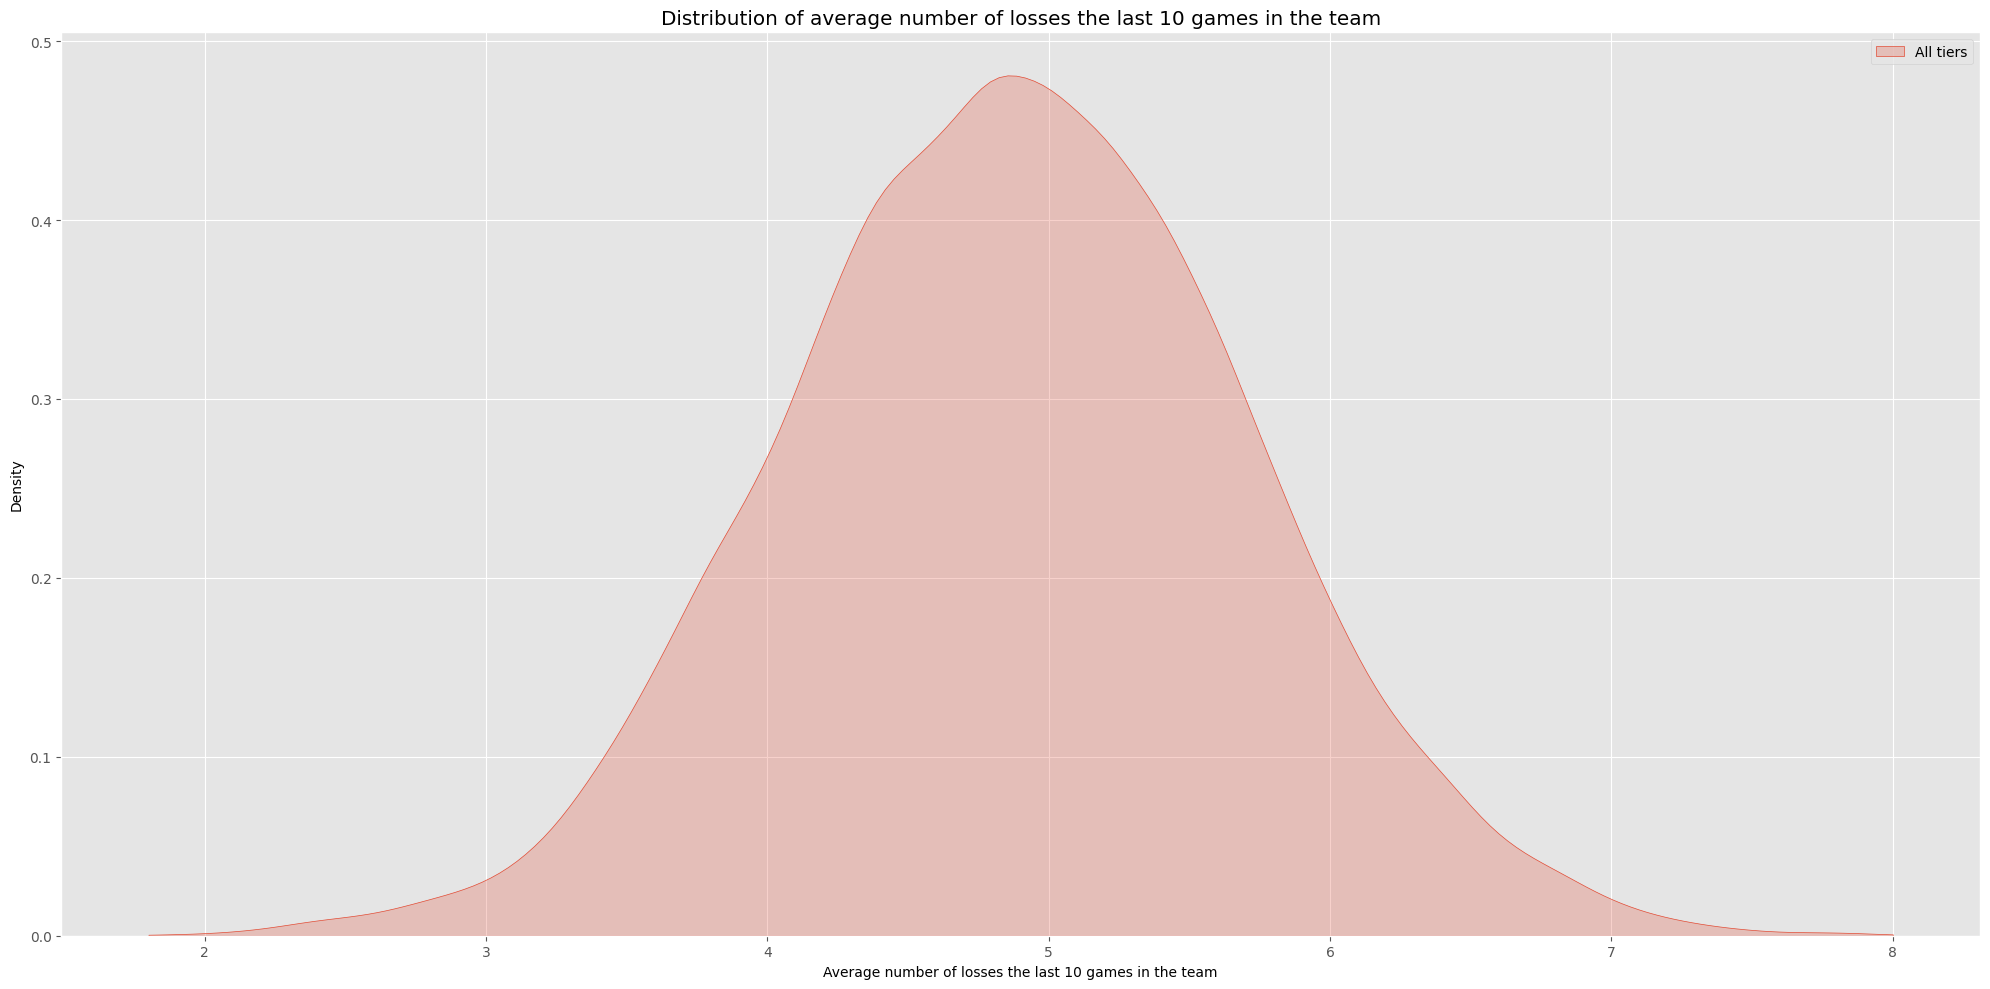

GLOBAL INFORMATION ON STAT
Average : 4.88
Median : 4.8
Max. : 8.0
Min. : 1.8
Variance : 0.677


In [54]:
create_plot(df=df_sum_of_losses_in_the_last_10_games,
            title="Distribution of average number of losses the last 10 games in the team",
            xlabel="Average number of losses the last 10 games in the team")

print_stats(df=df_sum_of_losses_in_the_last_10_games)

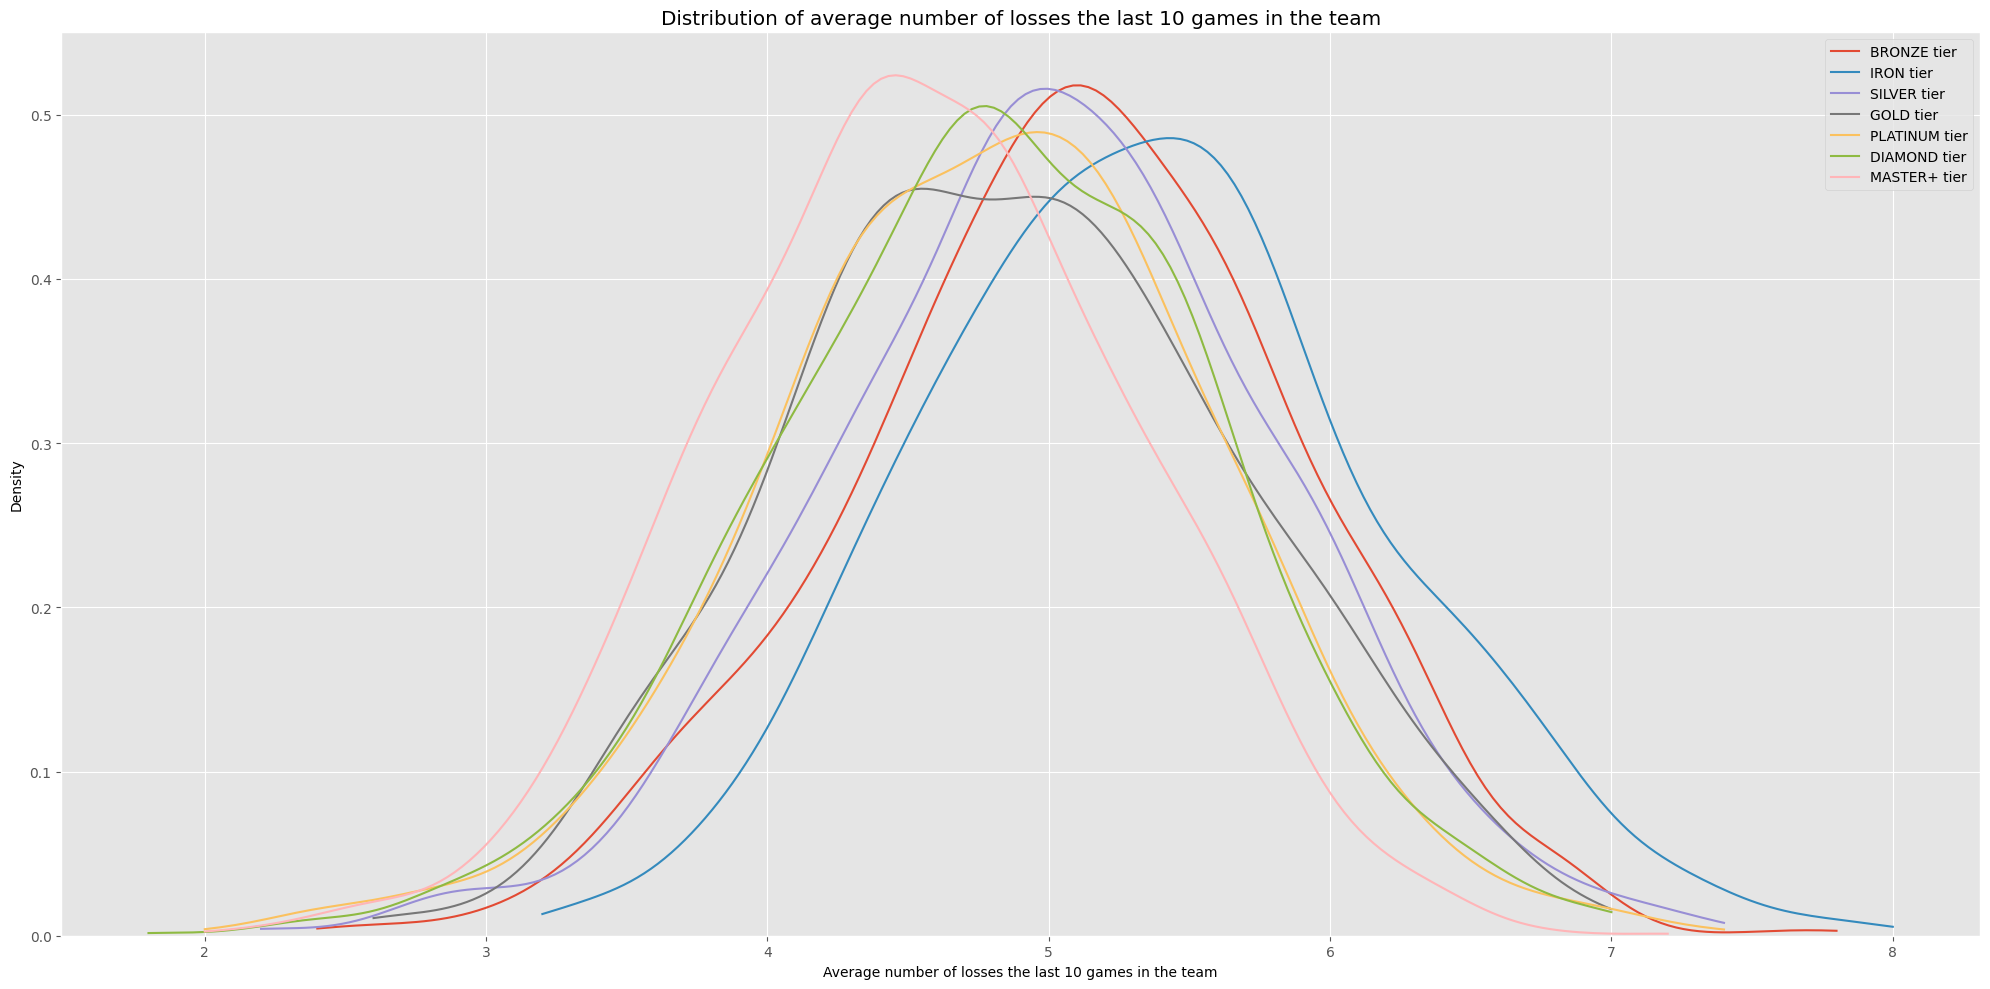

INFORMATION ABOUT THE STAT OF THE TIER : 'BRONZE'
Average : 5.09
Median : 5.2
Max. : 7.8
Min. : 2.4
Variance : 0.613
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'IRON'
Average : 5.36
Median : 5.4
Max. : 8.0
Min. : 3.2
Variance : 0.648
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'SILVER'
Average : 5.01
Median : 5.0
Max. : 7.4
Min. : 2.2
Variance : 0.635
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'GOLD'
Average : 4.88
Median : 4.8
Max. : 7.0
Min. : 2.6
Variance : 0.645
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'PLATINUM'
Average : 4.8
Median : 4.8
Max. : 7.4
Min. : 2.0
Variance : 0.638
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'DIAMOND'
Average : 4.81
Median : 4.8
Max. : 7.0
Min. : 1.8
Variance : 0.624
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'MASTER+'
Average : 4.56
Median : 4.6
Max. : 7.2
Min. : 2.0
Variance : 0.555
---------------


In [55]:
create_plot(df=df_sum_of_losses_in_the_last_10_games,
            title="Distribution of average number of losses the last 10 games in the team",
            xlabel="Average number of losses the last 10 games in the team",
            categories=True)

print_stats(df=df_sum_of_losses_in_the_last_10_games, categories=True)

### 3. The number of defeats / victories in a row

On prend le résultat de la dernière partie du joueur :
  - Si c'est une victoire, on compte son nombre de victoire d'affilées
  - Si c'est une defaite, on compte son nombre de défaites d'affilées et on met un moins devant
  
Exemple:
 - Joueur 1: 3 défaites d'affilées (-3)
 - Joueur 2: 1 victoire d'affilées (1)
 - Joueur 3: 3 victoires d'affilées (3)
 - Joueur 4: 2 défaites d'affilées (-2)
 - Joueur 5: 2 défaites d'affilées (-2)
 
  Valeur de la stat : -0.6

In [56]:
def apply_number_of_defeats_or_victories_in_a_row(x):
    count = 0
    if len(x) == 0:
        return None

    first_result = x[0]["result"]
    for d in x:
        if d["result"] == "victory":
            count += 1
        if d["result"] == "defeat":
            count -= 1
        if d["result"] != first_result:
            return count

In [57]:
df_number_of_defeats_or_victories_in_a_row = create_df_with_statitic(df_no_duplicates, apply_number_of_defeats_or_victories_in_a_row)

In [58]:
print(f"Number of teams : {df_number_of_defeats_or_victories_in_a_row.shape[0]}")

Number of teams : 9856


In [59]:
# Distribution of teams by tier
df_number_of_defeats_or_victories_in_a_row.tier.value_counts()

MASTER+     2110
DIAMOND     1546
PLATINUM    1262
GOLD        1246
SILVER      1234
BRONZE      1232
IRON        1226
Name: tier, dtype: int64

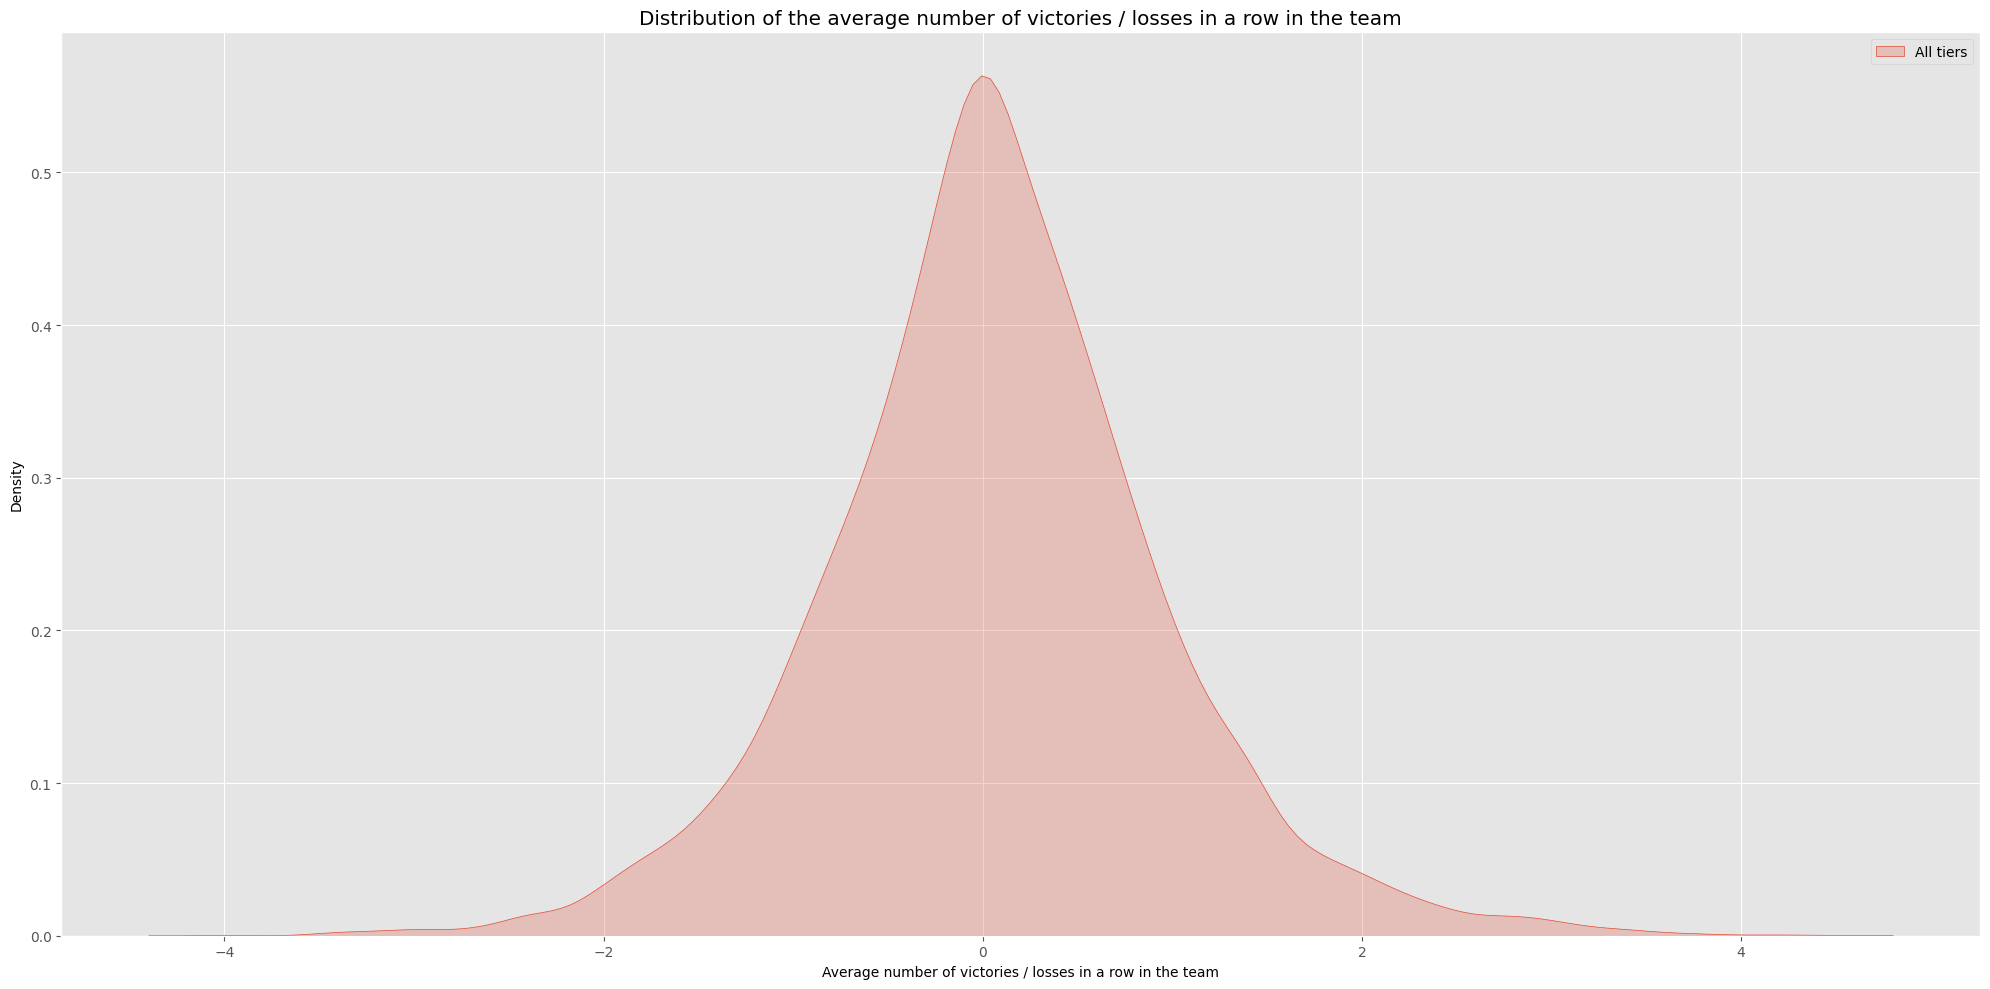

GLOBAL INFORMATION ON STAT
Average : 0.0608
Median : 0.0
Max. : 4.8
Min. : -4.4
Variance : 0.808


In [60]:
create_plot(df=df_number_of_defeats_or_victories_in_a_row,
            title="Distribution of the average number of victories / losses in a row in the team",
            xlabel="Average number of victories / losses in a row in the team")

print_stats(df=df_number_of_defeats_or_victories_in_a_row)

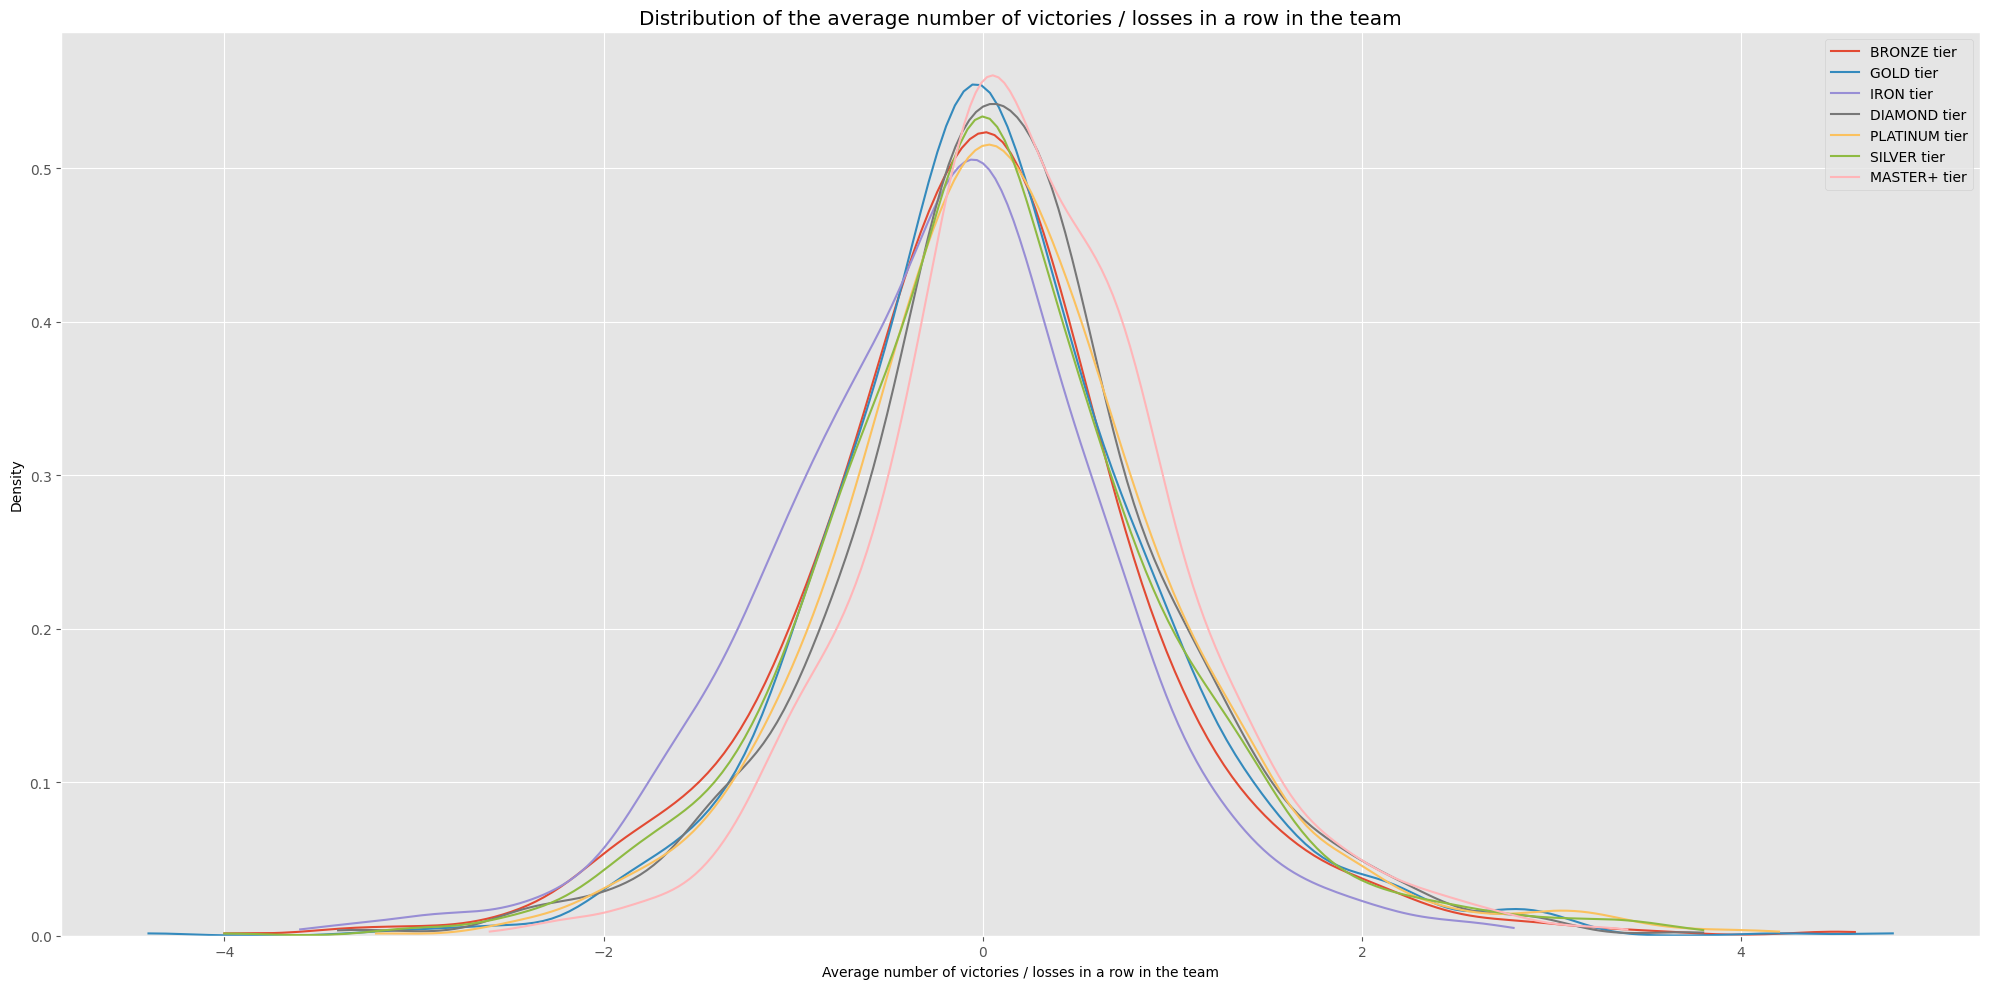

INFORMATION ABOUT THE STAT OF THE TIER : 'BRONZE'
Average : -0.0443
Median : 0.0
Max. : 4.6
Min. : -4.0
Variance : 0.863
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'GOLD'
Average : 0.0496
Median : 0.0
Max. : 4.8
Min. : -4.4
Variance : 0.784
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'IRON'
Average : -0.233
Median : -0.2
Max. : 2.8
Min. : -3.6
Variance : 0.791
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'DIAMOND'
Average : 0.109
Median : 0.0
Max. : 3.8
Min. : -3.4
Variance : 0.789
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'PLATINUM'
Average : 0.131
Median : 0.0
Max. : 4.2
Min. : -3.2
Variance : 0.834
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'SILVER'
Average : 0.0339
Median : 0.0
Max. : 3.8
Min. : -4.0
Variance : 0.87
---------------
INFORMATION ABOUT THE STAT OF THE TIER : 'MASTER+'
Average : 0.237
Median : 0.2
Max. : 3.4
Min. : -2.6
Variance : 0.67
---------------


In [61]:
create_plot(df=df_number_of_defeats_or_victories_in_a_row,
            title="Distribution of the average number of victories / losses in a row in the team",
            xlabel="Average number of victories / losses in a row in the team",
            categories=True)

print_stats(df=df_number_of_defeats_or_victories_in_a_row, categories=True)